$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
</head>
<body>
    
    
<div style="font-family:Georgia" align="center">
<h1 align="center">Quantum mechanics - Computation activities</h1>
<h1 align="center"><span style="text-decoration: gray underline overline" > Numerical integration of the Schrödinger equation</span></h1>
    
<br>
<br>
<br>
    
<h3> By: </h3>
<h3> Maxime Legrand </h3>
<h3> Chiari Even </h3>
    
<br>
<br>
<br>
    
<h3> Supervisor :</h3>
<h3> David Viennot </h3>
    
<br>
<br>
<br>

<h4> $5^{th}$ november 2022 <h4> 

    
    
</div>
</body> 
</html>

<h1 style="font-family:Georgia;text-decoration:gray underline">Introduction :</h1>

The main obejctive of this document is to solve the time dependant Schrödinger equation by applying it to a dynamical system leading to a counter-intuitive phenomena : the STImulated Raman Adiabatic Passage (STIRAP).

The approach will be leaded as it follows :

- Construction of the different used objects
- Statements of intuition towards the system evolution for multiple configurations
- Comparison with numerical results, enlighment and discussion of differences

<h1 style="font-family:Georgia;text-decoration:gray underline">Requirements and limits :</h1>

This program was made under Python 3.8.10 and may not work properly with previous versions. Also please consider having the following libraries installed :

- Numpy
- Scipy
- Matplotlib

A range of stability will be specified concerning the Richardson integrator, consider respecting it to properly interpret the results.

<h1 style="font-family:Georgia;text-decoration:gray underline">Construction of the different used objects :</h1>
<h2 style="font-family:Georgia;text-decoration:gray"> Parameters :</h2>

Here is the list of adjustable parameters used for this practical work :

In [1]:
import numpy as np
from numpy import linalg as LA
from scipy import linalg as LA2
import matplotlib.pyplot as plt

# Minimum time
T_MIN = -30

# Maximum time
T_MAX = 80

# Amount of samples (Critical value at 264-265)
N_TIME = 400

# Time step
DELTA_T = (T_MAX-T_MIN)/N_TIME

# Evaluated interval
T_EVAL = np.linspace(T_MIN, T_MAX, N_TIME)

# Error
EPSILON = 0.1

# Detunings
DELTA_P = 0.5
DELTA_S = -DELTA_P

# Width of pulses
TAU_S = 15
TAU_P = 15

# Peak positions
T_P = 10
T_S = 35

# Initial electric field
OMEGA_0 = 3.5

# H_bar
H_BAR = 1

# State matrix (initialized at 0)
STATE = np.array([[0,0,0]]*N_TIME, dtype='complex_')

# Initial state (default |1>)
STATE[0] = np.array([[1,0,0]], dtype='complex_')

Below is the function meant to normalize the states :

In [2]:
def Norm(vector):
    return(np.sqrt(np.conjugate(vector) @ vector))

<h2 style="font-family:Georgia;text-decoration:gray"> LASER pulses :</h2>

In order to stimulate the atom, one can use a Pump pulse which ensures the transition between state $\ket{1}$ and state $\ket{2}$ being quasi-resonant, and a Stokes pulse which ensures the transition between state $\ket{2}$ and state $\ket{3}$ also being quasi-resonant.

Let's first build the LASER fields used to stimulate the atom. They are Gaussian pulses defined by :
<br>
<br>
<center>$\begin{equation}
    \Omega_{P/S}(t) = \Omega_{0}e^{-(t-t_{P/S})^{2}/\tau^{2}_{S/P}}
\end{equation}$</center>

With :

- $t_{P/S}$ the time at which we want to send the pulse (based on the peak)
- $\tau_{S/P}$ the width of the pulse.

These are two simple functions described below :

In [3]:
# Stokes pulse
def Omega_s(t):
    return OMEGA_0 * np.exp(-(t-T_S)**2/(TAU_S)**2)

# Pump pulse
def Omega_p(t):
    return OMEGA_0 * np.exp(-(t-T_P)**2/(TAU_P)**2)

<h2 style="font-family:Georgia;text-decoration:gray"> Hamiltonian describing the system's dynamics :</h2>

This Hamiltonian is defined by :
<br>
<br>

<center>$\begin{equation}
H(\Omega_{P},\Omega_{S}) = \frac{\hbar}{2} 
\begin{pmatrix}
0 & \Omega_{P} & 0\\
\Omega_{P} & 2\Delta_{P} & \Omega_{S}\\
0 & \Omega_{S} & 2(\Delta_{P}-\Delta_{S})
\end{pmatrix}
\end{equation}$</center>

With :

- $\Delta_{P} = E_{2} - E_{1} - \hbar\omega_{P}$ the gap between atom transition energy level 2, 1 and the photon energy of the Pump LASER pulse
- $\Delta_{P} = E_{3} - E_{2} - \hbar\omega_{S}$ the gap between atom transition energy level 3, 2 and the photon energy of the Stokes LASER pulse

Which gives once coded :

In [4]:
def H(t):
    
    # initialization
    Mat = np.zeros((3,3))
    
    # Filling with corresponding objects
    Mat[1,0] = Omega_p(t)
    Mat[1,2] = Omega_s(t)
    
    # Applying the same (symmetric)
    Mat = Mat.transpose() + Mat
    
    # Filling the diagonal
    Mat[1,1] = 2*DELTA_P
    Mat[2,2] = 2*(DELTA_P- DELTA_S)

    return H_BAR/2 * Mat

<h2 style="font-family:Georgia;text-decoration:gray"> Integrators :</h2>
<h3 style="font-family:Georgia;text-decoration:gray"> Richardson integrator :</h3>

This method is based on the second order finite differences and is only stable in a certain range. This is equivalent to say that it exists a limit value of sampling $\Delta t$ above which the Richardson integrator diverges.

Its propagation scheme is the following :
<br>
<br>
<center>$\begin{equation}
    \Psi_{n+1} = \Psi_{n-1} - 2i\hbar^{-1} H(t_{n})\Psi_{n}\Delta t \label{3}
\end{equation}$</center>
<br>
<br>
With the mid point $\Psi_{1/2}$ obtainable with the use of Euler algorithm for the first iteration $\textbf{only}$ :
<br>
<br>
<center>$\begin{equation}
    \Psi_{1/2} = \Psi_{0} - i\hbar^{-1} H(t_{0})\Psi_{0}\frac{\Delta t}{2}
\end{equation}$</center>
<br>
<br>
Then all the other points are obtained through the usage of equation (3)
with respect to sampling indexes.
<br>
<br>
$\textit{Note : Euler algorithm is only used to initialize the integration due to its high instability regarding systems including complex numbers.}$
<br>
<br>
All of that gives :

In [5]:
def Richardson(psi):
    
    # Initialization of psi (mid point and first value)
    psihalf = psi[0] - 1j * H(T_MIN) @ psi[0] * DELTA_T/2
    psi[1] = psi[0] -1j * H(T_MIN+(DELTA_T/2)) @ psihalf * DELTA_T

    # Computation of psi for each time step with respect to the error criteria
    for i in range(1,N_TIME-1):
        psi[i+1] = psi[i-1] - 2*1j*H(T_MIN+i*DELTA_T) @ psi[i] * DELTA_T

        if np.sqrt(np.conj(psi[i+1]) @ psi[i+1]) > 1+EPSILON :
            print("It diverges")
            break
    
    # Normalization of each state
        psi[i+1] = psi[i+1]/Norm(psi[i+1])
        
    return psi

<h3 style="font-family:Georgia;text-decoration:gray"> Split operator method :</h3>

This method is based on the evolution operator with respect to the sampled time. One can get the evolution of the system from the initial time $t_{0}$ until the final time $T$ using the following relation :
<br>
<br>
<center>$\begin{equation}
    \Psi(T,t_{0}) = \Psi(t_{N},t_{N-1})\Psi(t_{N-1},t_{N-2}) ... \Psi(t_{1},t_{0})
\end{equation}$</center>
<br>
<br>
Leading to the propagation scheme :
<br>
<br>
<center>$\begin{equation}
    \Psi_{n+1} = e^{-i\hbar^{-1}H(t_{n})\Delta t} \Psi_{n}
\end{equation}$</center>
Which gives once coded :

In [6]:
def Split_Operator(Psi):
    
    for i in range(0,N_TIME-1):
        
        # Hamiltonian for each time step
        ham = (-1j/H_BAR) * H(T_MIN + (DELTA_T*i)) * DELTA_T
        
        # Computation of the scheme
        exp_m = LA2.expm(ham)
        Psi[i+1] = exp_m @ Psi[i]
        
        # Normalization of the state
        Psi[i+1] = Psi[i+1]/Norm(Psi[i+1])
        
    return Psi

<h3 style="font-family:Georgia;text-decoration:gray"> Comparison :</h3>

As previously said, the Split Operator method is unconditionally stable whereas the Richardson one presents a critical value above which it diverges, it can be found for $N_{TIME} = 264$ in the "Pump before Stokes" configuration. Here is an example :

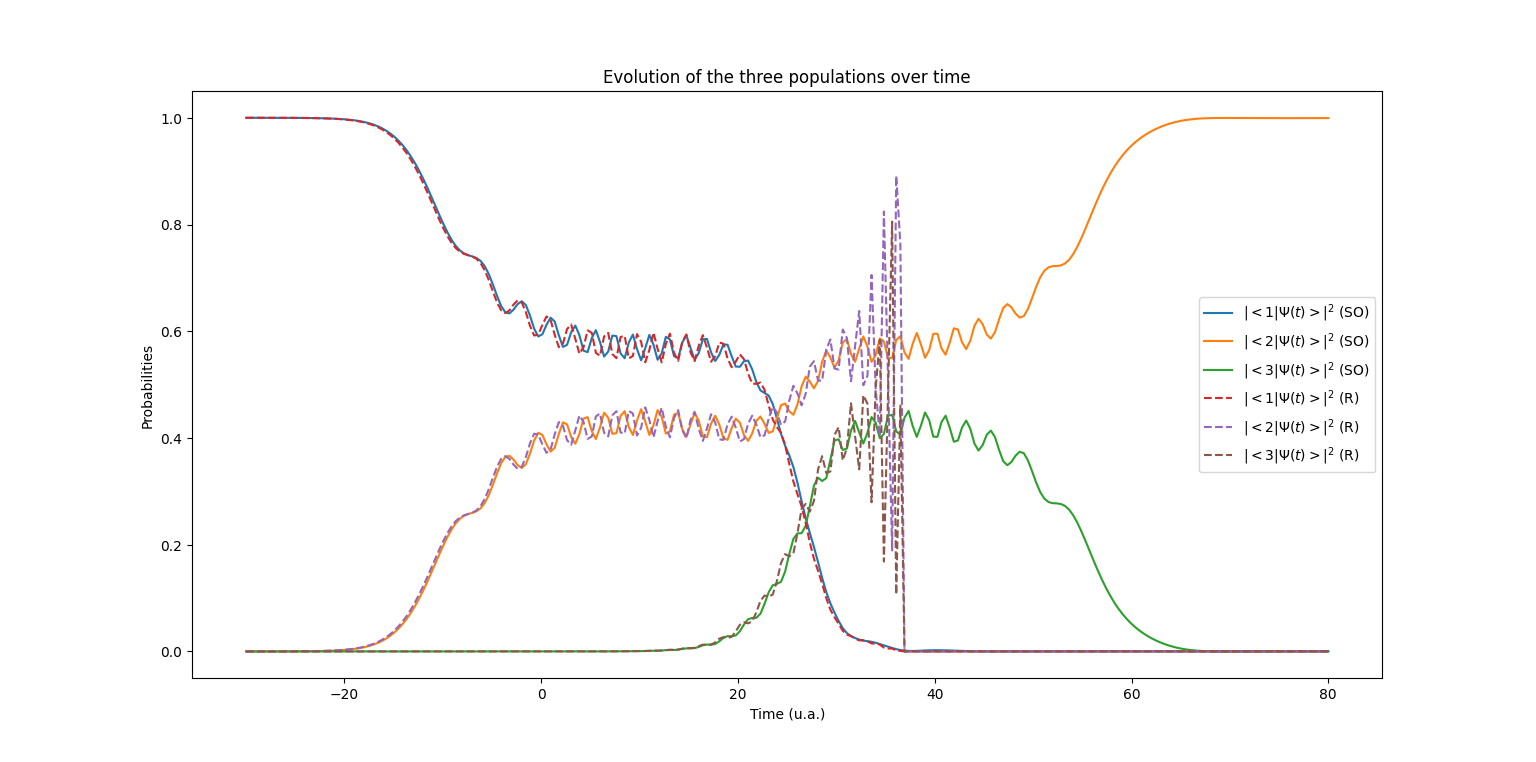

Populations associated to the Richardson integrator are the dotted lines (labeled by (R)), respectively the Split Operator ones are the continuous lines (labeled by (SO)). <b>We'll only be using the Split Operator for the rest of this practical work</b>.

<h2 style="font-family:Georgia;text-decoration:gray"> Integration of the Schrödinger equation $\&$ discussion :</h2>

All the tools introduced in the first part are now used to integrate the Schrödinger equation with a time-dependent Hamiltonian which obviously obeys the following equation :
<br>
<br>
<center>$\begin{equation}
    -i \hbar \dot\psi (t)=H(t)\psi(t)
\end{equation}$</center>
<br>
<br>
It is applied to a three level atom interacting with the two LASER pulses introduced before.

<h3 style="font-family:Georgia;text-decoration:gray"> LASER :</h3>

Below is the plot of the two LASER pulses :

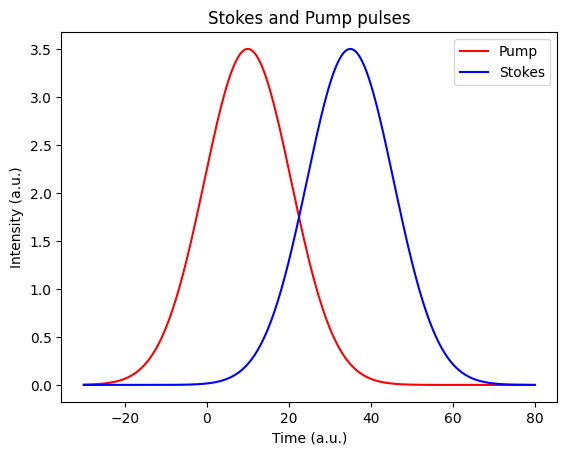

In [7]:
plt.plot(T_EVAL, Omega_p(T_EVAL), color='red', label='Pump')
plt.plot(T_EVAL, Omega_s(T_EVAL), color='blue', label='Stokes')
plt.xlabel('Time (a.u.)')
plt.ylabel('Intensity (a.u.)')
plt.title('Stokes and Pump pulses')
plt.legend()
plt.show()

On the graph the two Gaussian pulses that we have are crossing each other, this will be an important point when it comes to the study of which states our system ends after the numerical integration.

<h3 style="font-family:Georgia;text-decoration:gray"> Effect of LASER pulses on the state of our system :</h3>

Our goal is to integrate the Schrödinger equation with the two integrators (only keeping the Split Operator here) methods in order to :

- Compare the two methods (already done above)
- Draw the time-dependent population $t \mapsto |\braket{1}{\psi(t)}|^2 $, $t \mapsto |\braket{2}{\psi(t)}|^2 $, $t \mapsto |\braket{3}{\psi(t)}|^2 $
- Understand the influence of pulses fields on our system
- Compare the influence of the LASER order

<h4 style="font-family:Georgia;text-decoration:gray"> Case of pump before stokes :</h4>

Intuitively we would think the effect of sending frist pump and after stokes lead our system to end in state $\ket{3}$, because the influence of pump is to put the system in state $\ket{2}$ and the stokes raises the system in state $\ket{3}$. After the numerical integration, we don't find this. Here's the graph corresponding to this configuration :

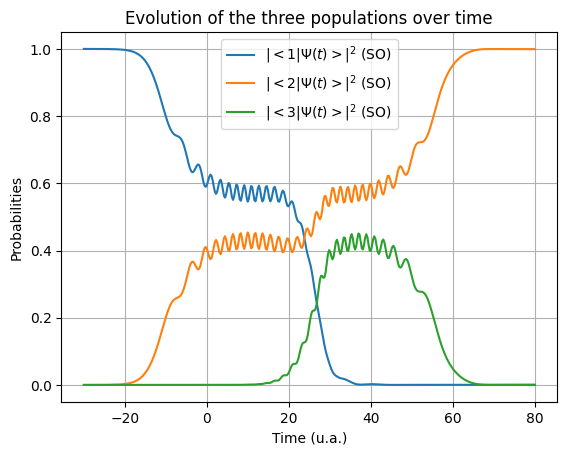

In [8]:
# Resolution by the Split Operator method
Psi1 = Split_Operator(STATE)

# Associated probabilities
P_split_operator = np.real((Psi1 * np.conjugate(Psi1)))

# Initialization of the state matrix
STATE = np.array([[0,0,0]]*N_TIME, dtype='complex_')
STATE[0] = np.array([[1,0,0]], dtype='complex_')

# Visualization
plt.plot(T_EVAL, P_split_operator[:,0], label=r'$|<1|\Psi (t)>|^{2}$ (SO)')
plt.plot(T_EVAL, P_split_operator[:,1], label=r'$|<2|\Psi (t)>|^{2}$ (SO)')
plt.plot(T_EVAL, P_split_operator[:,2], label=r'$|<3|\Psi (t)>|^{2}$ (SO)')
plt.xlabel('Time (u.a.)')
plt.ylabel('Probabilities')
plt.grid()
plt.title('Evolution of the three populations over time')
plt.legend()
plt.show()

The initial state of the system is $\ket{1}$. This can be confirmed with the fact that the probability to find the system in state one at the begininning is equal to 1 whereas the other are all 0.

In a second time, the pump pulse gives energy to the atom in order to pass in state $\ket{2}$, so the probability to find the system in state $\ket{1}$ decreases whereas the probability of the state $\ket{2}$ increases with respect to their sum always equal to 1.

Then the stokes pulse starts and the pump one is starting to decrease, here the probability to find the system in state $\ket{1}$ is decreasing, the probability to find it in state $\ket{3}$ increases and same for the probability of state $\ket{2}$. It means the atom in state being in $\ket{2}$ has enough energy to pass in state $\ket{3}$ and the probability of the first one collapses to 0.

After the time 40 the pump is lighted off, we can find the system in the state $\ket{2}$ or $\ket{3}$ because only the stokes pulse is interacting with our system and due to the fact states $\ket{2}$ and $\ket{3}$ are quasi resonant.

Finally the system remains in the state $\ket{2}$ when we cut off the Stokes pulse. It is due to the fact that state $\ket{2}$ is the least energetic regarding $\ket{3}$ so the atom "chooses" the reamain in the less energetic one.

We will argue towards this possible answer during the study of eigenvalues.

<h4 style="font-family:Georgia;text-decoration:gray">Case of Stokes before pump :</h4>

In this part we are going to study the same system except that we'll send the Stokes pulse before the Pump one.

By thinking the same way as in the previous part, one could intuitively say that the system would remain in its initial state. Indeed, the Stokes pulse is responsible of the transition between $\ket{2}$ and $\ket{3}$ and is sent when the system is in the state $\ket{1}$. By plotting the results below, we realize once more that the system state doesn't end in the state we except it would. Instead, it is in state $\ket{2}$.

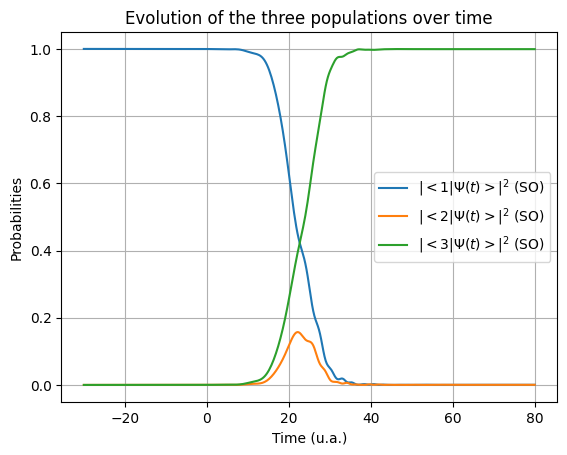

In [9]:
# Switching parameters for the 2nd case
T_P=35
T_S=10

# Resolution by the Split Operator method
Psi1 = Split_Operator(STATE)

# Associated probabilities
P_split_operator = np.real((Psi1 * np.conjugate(Psi1)))

# Initialization of state matrix
STATE = np.array([[0,0,0]]*N_TIME, dtype='complex_')
STATE[0] = np.array([[1,0,0]], dtype='complex_')

# Visualization
plt.plot(T_EVAL, P_split_operator[:,0], label=r'$|<1|\Psi (t)>|^{2}$ (SO)')
plt.plot(T_EVAL, P_split_operator[:,1], label=r'$|<2|\Psi (t)>|^{2}$ (SO)')
plt.plot(T_EVAL, P_split_operator[:,2], label=r'$|<3|\Psi (t)>|^{2}$ (SO)')
plt.xlabel('Time (u.a.)')
plt.ylabel('Probabilities')
plt.grid()
plt.title('Evolution of the three populations over time')
plt.legend()
plt.show()


We can see by following the 3 curves over time that the system is obviously in the state $\ket{1}$ at the beginning, then once the two pulses are "crossing" each other, one can see that state $\ket{2}$ becomes a transition state, meaning that its role is only to grant access from $\ket{1}$ to $\ket{3}$. Then the atom energy sticks in state $\ket{3}$.

An explanation to this strange phenomena is that there is a short period of time during which both Stokes and Pump are acting on the system. It opens both transitions (between $\ket{1}$ and $\ket{2}$, and between $\ket{2}$ and $\ket{3}$) which allow the energy to rise up to $\ket{3}$. As the Stokes pulse decreases during this short period until it reaches 0, all the electrons are trapped in the state $\ket{3}$ and thus the atom is in the most excited configuration.

<h4 style="font-family:Georgia;text-decoration:gray">Evolution of Eigenvalues over time :</h4>


Now we want study the eigenvalues of our Hamiltonian $H(\Omega_{p}(t),\Omega_{s}(t))$ for the same cases than before, in order to get the Eigenvalues at each time step we use LA.eigvalsh.

This is a function diagonalizing our Hamiltonian and giving us the normalized eigenvalues ordered in an increasing order.

In [10]:
# Function to get Eigenenergies
def Diag(list): 
    
    # Computation over time steps
    for i in range(0,N_TIME): 
        
        # Getting the sorted normalized Eigenvalues
        list[i]=LA.eigvalsh(H(T_MIN+i*DELTA_T))
        
    return list
    

<h4 style="font-family:Georgia;text-decoration:gray">Case of pump before Stokes :</h4>


Another approach to try to understand this counter-intuitive phenomenon is to plot the evolution of Eigenvalues over time :

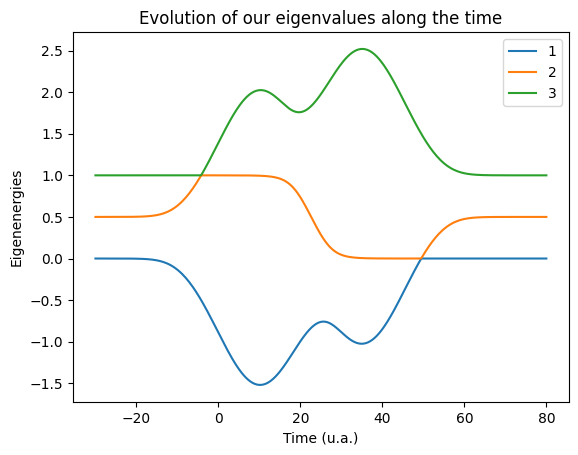

In [11]:
# Switching parameters for 1st case
T_P=10
T_S=35

# Building the Eigenenergy matrix
EIGENVALUE=np.array([[0,0,0]]*N_TIME, dtype='complex_')#Our array of zero that we are going to fill with the code before

# Getting them over time
eigen=Diag(EIGENVALUE)
eigen=eigen.real()

# Visualization
plt.plot(T_EVAL, eigen[:,0], label=r'1')
plt.plot(T_EVAL, eigen[:,1], label=r'2')
plt.plot(T_EVAL, eigen[:,2], label=r'3')
plt.xlabel('Time (u.a.)')
plt.ylabel('Eigenenergies')
plt.title("Evolution of our eigenvalues along the time")
plt.legend()
plt.show()

On this graph, each three curves correspond to each Eigenenergy of our Hamiltonian during the time.
These curves are crossing each other twice but the colors of our curves are like "shifting". This can be explained because the eigenvalues are sorted by increasing values, this shift means the eigenvalues are swapping in reason of the ordered eigenvalues. 

This graph can explain the final state of our system, if we follow the eigenvalue of the state one we can see the curve decreasing, after few times it increases then crosses the curve of the second eigenvalue corresponding to state $\ket{2}$. It switches state when crossing in favor of the less drifting curve, in the case the one corresponding to $\ket{2}$. It is very visual in order to understand why our system remains in state two after the two pulses.

<h4 style="font-family:Georgia;text-decoration:gray">Case of Stokes before pump :</h4>


Now we'll plot the eigenvalues along the time sending Stokes before Pump :

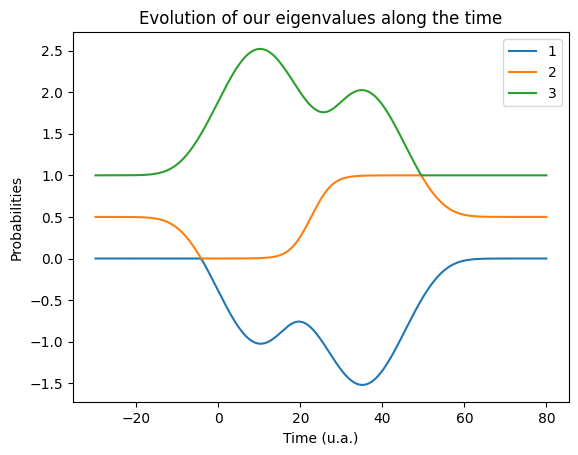

In [12]:
# Switching parameters for 2nd case
T_P=35
T_S=10

# Building the Eigenenergy matrix
EIGENVALUE=np.array([[0,0,0]]*N_TIME, dtype='complex_')#Our array of zero that we are going to fill with the code before

# Getting them
eigen=Diag(EIGENVALUE)
eigen=eigen.real

# Visualization
plt.plot(T_EVAL, eigen[:,0], label=r'1')
plt.plot(T_EVAL, eigen[:,1], label=r'2')
plt.plot(T_EVAL, eigen[:,2], label=r'3')
plt.xlabel('Time (u.a.)')
plt.ylabel('Eigenenergies')
plt.title("Evolution of our eigenvalues along the time")
plt.legend()
plt.show()

This graph is like the previous one, it is just the symmetrical of it with respect to the x-axis. 

We can interpret this like the previous order of our pulses, at the beginning we are in the state one.
We can see the blue curve is crossing the orange one so the atom switches state, if we follow our original eigenvalue our system is now in state $\ket{2}$.
After the curve has crossed the green one relative to the state $\ket{3}$, the atom rises in state $\ket{3}$ stays in this state until the end of the simulation. This is following the result for our second graph in the first part. 

<h1 style="font-family:Georgia;text-decoration:gray underline">Conclusion :</h1>

In this numerical study of the Schrödinger equation, we have learnt and coded various objects allowing us to understand :

- The behavior of Gaussian pulses (Pump and Stokes) which had the same equation but were respectively relative to the first transition $\ket{1} \xrightarrow{} \ket{2}$ and to the second transition $\ket{2} \xrightarrow{} \ket{3}$.

- How to build an Hamiltonian which takes several parameters containing the information about energy in our system. 

- Two integrators, the Richardson one that which partly uses Euler algorithm to compute the evolution along time of $\Psi(t)$ (and can diverge for $\Delta t$ too big) and the Split Operator one which used an algorithm based on the group rule of the evolution operator to compute $\Psi(t)$. 

- We've done these simulations for 2 configurations and plotted the evolution of time depend population $t \mapsto |\braket{1}{\psi(t)}|^2 $, $t \mapsto |\braket{2}{\psi(t)}|^2 $, $t \mapsto |\braket{3}{\psi(t)}|^2 $. 

- We tried to predict the result of our simulation and failed each time, this showed the counter-intuitive quantum effect of our system called STImulated Raman Adiabatic Passage (STIRAP).

- Finally with the simulation of our eigenvalues for our system, we have succeeded in understanding the STIRAP effect we observed in the previous simulations and we think the final state can be predicted by the study of Eigenenergies because by having done this for a huge variety of initial conditions, it allowed each time to predict the final state.